# Rank Funding Agencies

## Years: 2008-2018

## 1) General imports and utility functions

In [224]:
import time
import requests
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from py2neo import Graph, Node, Relationship
import os
import math

min_year = 2008
max_year = 2018
years = '[%d : %d]' % (min_year, max_year)
data_dir = "data"
grants_data_dir = "grants"
pubs_data_dir = "publications"

In [89]:
import requests

#   The credentials to be used
login = {
    'username': 'jww@mit.edu',
    'password': 'e38qDkG$tJ'
}

#   Send credentials to login url to retrieve token. Raise
#   an error, if the return code indicates a problem.
#   Please use the URL of the system you'd like to access the API
#   in the example below.
resp_auth = requests.post('https://app.dimensions.ai/api/auth.json', json=login)
resp_auth.raise_for_status()

#   Create http header using the generated token.
headers = {
    'Authorization': "JWT " + resp_auth.json()['token']
}

In [3]:
graph = Graph( "bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

def neo4j_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df
    
top_5 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science']
top_10 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science', 'Journal of the American Chemical Society', 'JAMA', 'The New England Journal of Medicine', 'Nature Genetics', 'Neuron']
top_42 = ['Angewandte Chemie','Blood','Cancer Cell','Cancer Discovery','Cancer Research','Cell','Cell Host & Microbe','Cell Metabolism','Cell Stem Cell','Chemistry & Biology','The EMBO Journal','Genes & Development','Immunity','Journal of Neurology','Journal of the American Chemical Society','JAMA','Journal of Biological Chemistry','Journal of Cell Biology','Journal of Clinical Investigation','Journal of Experimental Medicine','Journal of Medicinal Chemistry','The Lancet','Nature Cell Biology','Nature Chemical Biology','Nature Chemistry','Nature Medicine','Nature Methods','Nature','Nature Biotechnology','The New England Journal of Medicine','Neuron','Nature Genetics','Nature Immunology','Nature Neuroscience','Nature Structural & Molecular Biology','PLOS Biology','PLOS Genetics','PLOS Pathogens','Proceedings of the National Academy of Sciences of the United States of America','Science Signaling','Science Translational Medicine','Science']

Connected to graph database with 758,202,144 nodes and 3,482,624,148 relationships!


In [4]:
# long numbers to human readable string
def human_format(num):
    try:
        num = float('{:.3g}'.format(float(num)))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    except:
        return num

In [101]:
from requests.exceptions import HTTPError
import time

last_dimensions_query = time.time()
def dimensions_to_df(query):
    global last_dimensions_query
    d = time.time() - last_dimensions_query
    if d < 2:
        time.sleep(d)
    last_dimensions_query = time.time()
    try:
        resp = requests.post(
            'https://app.dimensions.ai/api/dsl.json',
            data=query.encode(),
            headers=headers)
        resp.raise_for_status()
    except HTTPError as http_err:
        print('Error while executing query: ', query)
        raise http_err
    ret = resp.json()
    keys = list(ret.keys())
    keys.remove('_stats')
    if len(keys):
        df = pd.DataFrame(ret[keys[0]])
    else:
        df = pd.DataFrame()
    return df, ret['_stats']

## 2) General rankings of funders

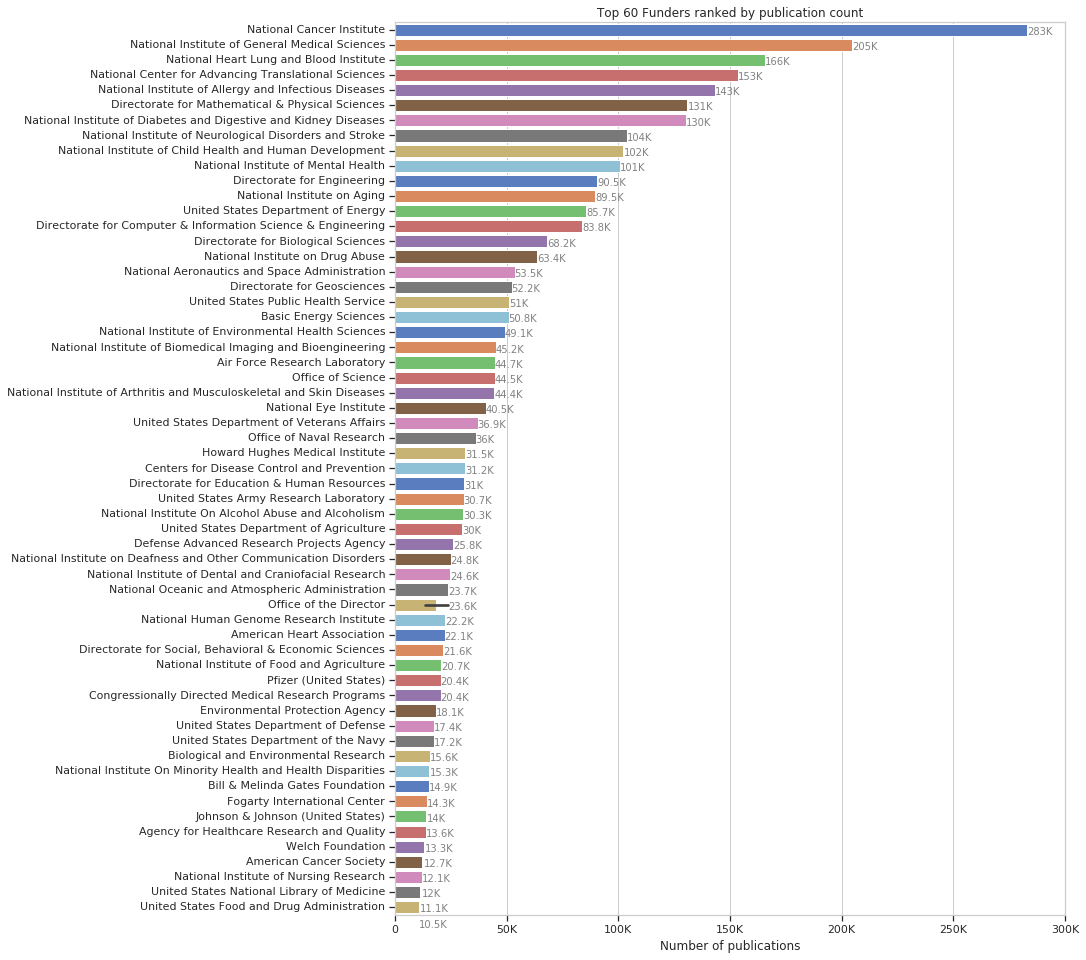

In [6]:
# US Funders ranked by number of publications

query = (
    'search publications ' +
    'where funder_countries = "US" ' +
    'and year in ' + years + 
    ' return funders limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "count", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 Funders ranked by publication count')
ax.set_ylabel('')
ax.set_xlabel('Number of publications')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['count'], index + 0.33, human_format(row['count']), color='gray')
plt.show()

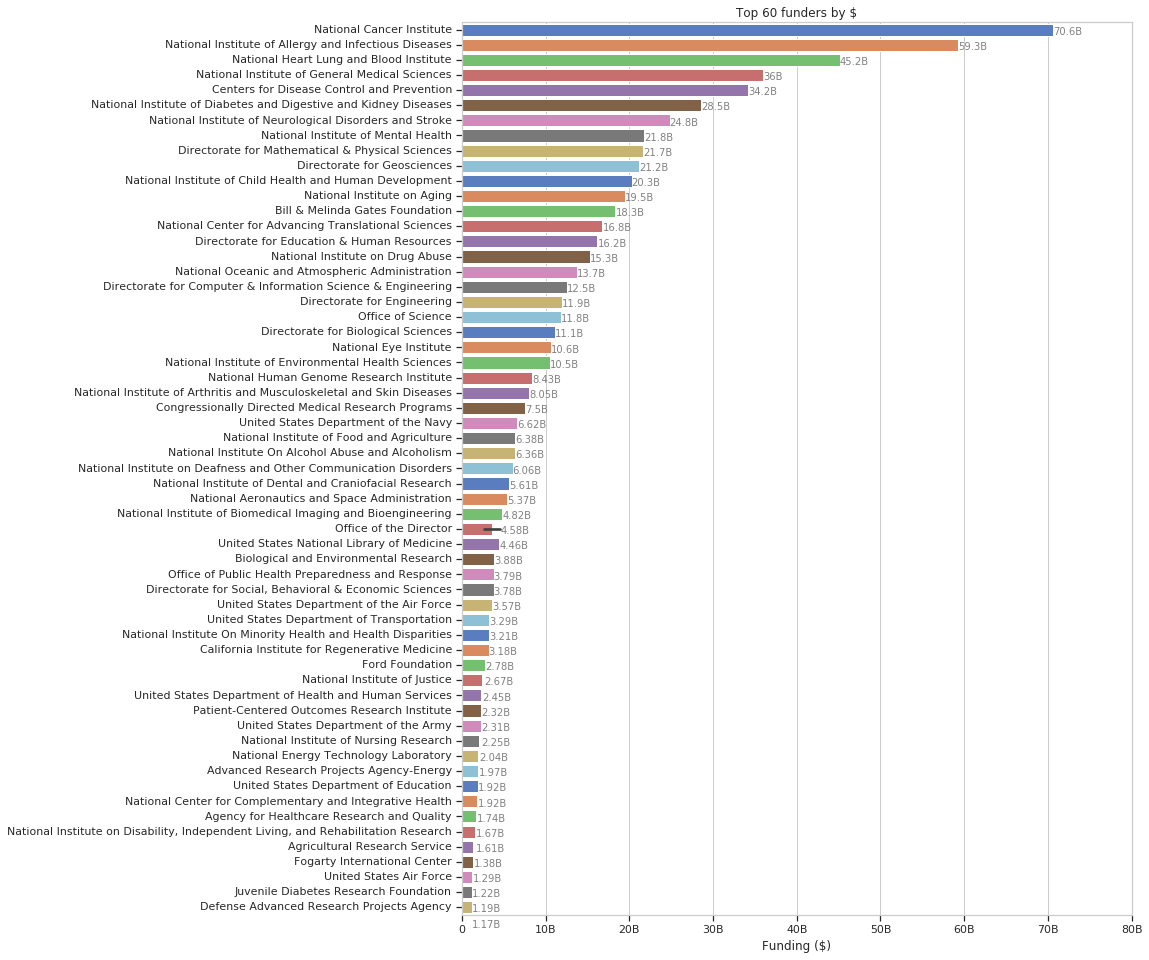

In [7]:
# US funders ranked by funding amount

query = (
    'search grants ' +
    'where funder_countries = "US" ' +
    'and active_year in ' + years + 
    ' return funders ' +
    'aggregate funding ' +
    'sort by funding desc limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60).reset_index()
top100 = df[df['country_name'] == 'United States'].head(100).reset_index()
over100m = df[df['country_name'] == 'United States']
over100m = df[df['funding'] > 1e8]


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "funding", data=only_us, orient="h", palette="muted")
ax.set_title('Top 60 funders by $')
ax.set_ylabel('')
ax.set_xlabel('Funding ($)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
for index, row in only_us.iterrows():
    ax.text(row['funding'], index + 0.33, human_format(row['funding']), color='gray')
plt.show()

## 4) Fetch Dimensions data
### *NOTICE - only needed if you want the whole data stored locally. Otherwise, skip to (5)*

In [ ]:
# Fetch all grants for all top 100 funders

for index, row in over100m.iterrows(): 
    if row['name'] == 'Alfred P. Sloan Foundation':
        filename = "%s/%s.csv" % (grants_data_dir, row['name'])
    else:
        filename = "%s/%s.csv" % (grants_data_dir, row['acronym'])
    if os.path.isfile(filename):
        continue
    
    print("Fetching grants for #%d - %s" % (index, row['name']))
    query = (
        'search grants ' +
        'where funders.name = "' + row['name'] + '" ' + 
        'and active_year in ' + years + 
        'return grants [all - abstract - original_title] ' + 
        'sort by id ' +
        'limit 1000 skip '
    )

    big_df, stats = dimensions_to_df(query + "0")
    total = stats['total_count']

    if total > 50000:
        raise Exception("Total number of grants for this funder exceeds the maximum fetch-able amount", total)

    start = 1
    step = 1000
    idx = start
    for i in range(start * step, total, step):
        print("%.1f%%" % (float(i) * 100 / total))
        df, stats = dimensions_to_df(query + "%d" % i)
        big_df = pd.concat([big_df, df])
        
    big_df.to_csv(filename)
    print("Done. Saved to " + filename)

print("ALL Done.")

In [8]:
# Aggregate publications

names = ['"%s"' % s for s in over100m['name']]

query = (
    'search publications ' +
    'where funders.name in [' + ','.join(names) + '] ' + 
    'and year in ' + years + 
    ' return funders ' + 
    'aggregate count, citations_total, citations_avg, altmetric_median, rcr_avg, fcr_gavg ' +
    'limit 1000'
)
df, stats = dimensions_to_df(query)
metrics = df[df['name'].isin(over100m['name'])]

In [170]:
def func(x):
    return np.sum(x)

a = over100m[['name', 'funding', 'count']].groupby(['name'], as_index=False).agg('sum')
b = metrics.groupby(['name'], as_index=False).agg(func)

data = pd.merge(a, b, on='name')
data.rename(columns={'count_x':'count_grants',
                                'count_y':'count_publications'},inplace=True)
data

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg
0,Advanced Research Projects Agency-Energy,1.924743e+09,816,ARPA-E,3.000000,22.777453,38995.0,1712,United States,3.557847,grid.452934.d,1.802529
1,Agency for Healthcare Research and Quality,1.669719e+09,2497,AHRQ,5.000000,23.904262,325839.0,13631,United States,3.042887,grid.413404.6,1.765356
2,Alfred P. Sloan Foundation,6.830126e+08,1815,0,4.000000,35.875538,258268.0,7199,United States,4.011436,grid.453006.4,1.954173
3,Alzheimer's Association,2.059814e+08,1153,ALZ,7.000000,42.558326,201386.0,4732,United States,3.872184,grid.422384.b,2.479414
4,American Association For Cancer Research,2.532018e+08,570,AACR,8.750000,94.960951,55932.0,589,United States,6.730427,grid.280840.6,4.911987
5,Arnold and Mabel Beckman Foundation,1.041106e+08,894,Beckman,3.000000,53.327576,86444.0,1621,United States,3.508734,grid.453228.a,2.345518
6,Arthritis Foundation,1.065859e+08,597,AF,3.000000,40.302417,61703.0,1531,United States,3.325254,grid.422901.c,1.925134
7,Autism Speaks,1.197731e+08,597,Autism Speaks,6.000000,60.556574,132195.0,2183,United States,5.136740,grid.427598.5,2.814631
8,Bill & Melinda Gates Foundation,1.833299e+10,6425,BMGF,4.895604,35.349983,527952.0,14935,United States,3.606500,grid.418309.7,2.824802
9,Biological and Environmental Research,3.882828e+09,1920,BER,3.000000,31.457798,489735.0,15568,United States,2.893142,grid.452963.f,1.584671


In [171]:
# correction for future and past fundings
import math
data['funding_correction'] = 0
for index, row in data.iterrows(): 
    print("Loading grants for #%d - %s" % (index, row['name']))
    if row['name'] == "Alfred P. Sloan Foundation":
        df = pd.read_csv('%s/Alfred P. Sloan Foundation.csv' % grants_data_dir)
    elif row['name'] == "Office of the Director":
        df = pd.concat([pd.read_csv('%s/OD.csv' % grants_data_dir), pd.read_csv('%s/NSF OD.csv' % grants_data_dir)])
    else:
        df = pd.read_csv('%s/%s.csv' % (grants_data_dir, row['acronym']))
    deduct_funding = 0
    for index2, row2 in df[df['active_year'].str.contains('2019') | df['active_year'].str.contains('2007')].iterrows():
        if not math.isnan(row2['funding_usd']):
            active_years = [int(s.strip()) for s in row2['active_year'][1:-1].split(',')]
            non_relevant_years = [year for year in active_years if year > max_year or year < min_year]
            deduct_funding += float(len(non_relevant_years)) * row2['funding_usd'] / len(active_years)
    data.loc[index, 'funding_correction'] = deduct_funding

print("ALL Done.")
data["funding_corrected"] = data["funding"] - data["funding_correction"]

Loading grants for #0 - Advanced Research Projects Agency-Energy
Loading grants for #1 - Agency for Healthcare Research and Quality
Loading grants for #2 - Alfred P. Sloan Foundation
Loading grants for #3 - Alzheimer's Association
Loading grants for #4 - American Association For Cancer Research
Loading grants for #5 - Arnold and Mabel Beckman Foundation
Loading grants for #6 - Arthritis Foundation
Loading grants for #7 - Autism Speaks
Loading grants for #8 - Bill & Melinda Gates Foundation
Loading grants for #9 - Biological and Environmental Research
Loading grants for #10 - California Institute for Regenerative Medicine
Loading grants for #11 - Cancer Prevention and Research Institute of Texas
Loading grants for #12 - Center for Information Technology
Loading grants for #13 - Centers for Disease Control and Prevention
Loading grants for #14 - Commonwealth Fund
Loading grants for #15 - Congressionally Directed Medical Research Programs
Loading grants for #16 - Craig H Neilsen Foundatio

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading grants for #34 - National Cancer Institute


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading grants for #35 - National Center for Advancing Translational Sciences
Loading grants for #36 - National Center for Complementary and Integrative Health
Loading grants for #37 - National Center for Emerging and Zoonotic Infectious Diseases
Loading grants for #38 - National Center on Birth Defects and Developmental Disabilities
Loading grants for #39 - National Endowment for the Humanities
Loading grants for #40 - National Energy Technology Laboratory
Loading grants for #41 - National Eye Institute
Loading grants for #42 - National Heart Lung and Blood Institute
Loading grants for #43 - National Human Genome Research Institute
Loading grants for #44 - National Institute On Alcohol Abuse and Alcoholism
Loading grants for #45 - National Institute On Minority Health and Health Disparities
Loading grants for #46 - National Institute of Allergy and Infectious Diseases
Loading grants for #47 - National Institute of Arthritis and Musculoskeletal and Skin Diseases
Loading grants for #48 

In [ ]:
# download publication for funders
relevant_columns = "[author_affiliations + concepts + doi + date + year + journal + ]"

for funder in funders: 
    filename = "%s/%s.csv" % (pubs_data_dir, funder)
    if os.path.isfile(filename):
        continue

    print("Fetching publications for %s" % funder)
    query = (
        'search publications ' +
        'where funders.name = "' + funder + '" ' + 
        'and year in ' + years + 
        'return publications [all] ' + 
        'sort by id ' +
        'limit 1000 skip '
    )

    big_df, stats = dimensions_to_df(query + "0")
    total = stats['total_count']

    if total > 50000:
        raise Exception("Total number of publication for this funder exceeds the maximum fetch-able amount", total)

    start = 1
    step = 1000
    idx = start
    for i in range(start * step, total, step):
        print("%.1f%%" % (float(i) * 100 / total))
        df, stats = dimensions_to_df(query + "%d" % i)
        big_df = pd.concat([big_df, df])
        
    big_df.to_csv(filename)
    print("Done. Saved to " + filename)

print("ALL Done.")

In [226]:
filename = data_dir + "/funders_corrected.csv"
# Uncomment to save to data/funders.csv
data.to_csv(filename)

## 5) Plot Funding vs. Metrics

In [227]:
# Load funders data
filename = data_dir + "/funders_corrected.csv"
data = pd.read_csv(filename)

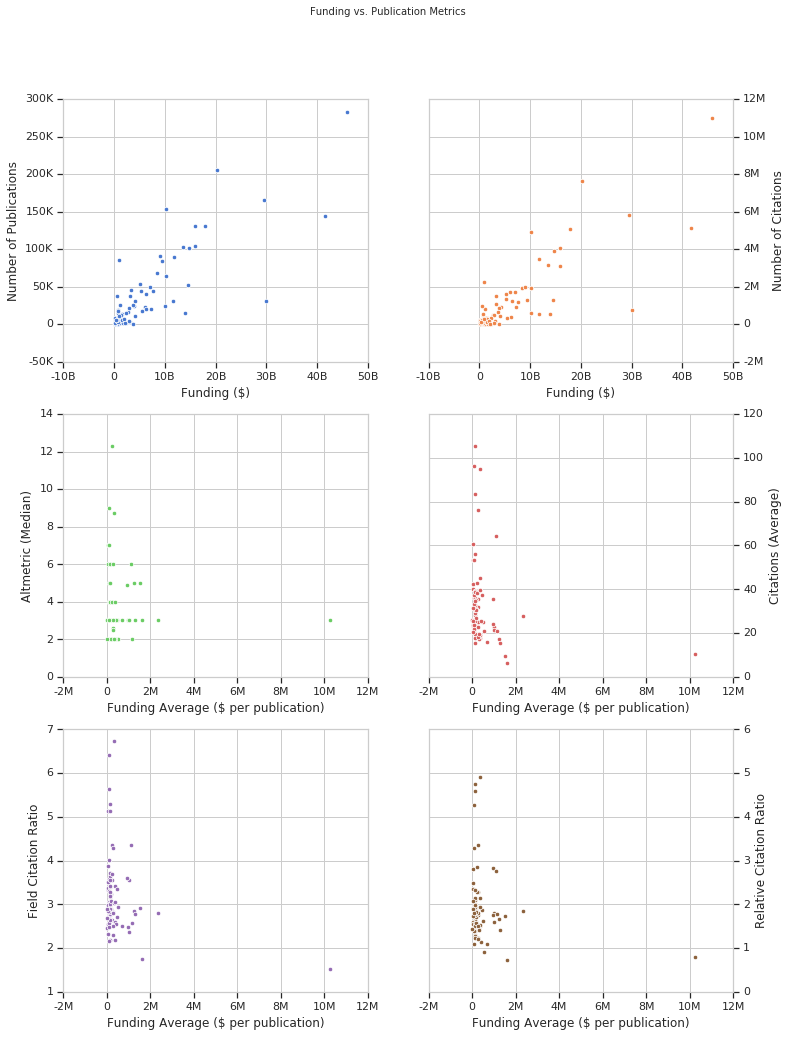

In [172]:
fig, axes = plt.subplots(3, 2, figsize=(12,16))
fig.suptitle('Funding vs. Publication Metrics') 
colors = np.array(sns.color_palette("muted"))

data["funding_avg"] = data["funding_corrected"] / data["count_publications"]

sns.scatterplot(ax = axes[0][0], x="funding_corrected", y="count_publications", data=data, color=colors[0])
axes[0][0].set_ylabel('Number of Publications')
axes[0][0].yaxis.tick_left()
axes[0][0].set_yticklabels([human_format(tick) for tick in axes[0][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[0][1], x="funding_corrected", y="citations_total", data=data, color=colors[1])
axes[0][1].set_ylabel('Number of Citations')
axes[0][1].yaxis.set_label_position("right")
axes[0][1].yaxis.tick_right()
axes[0][1].set_yticklabels([human_format(tick) for tick in axes[0][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][0], x="funding_avg", y="altmetric_median", data=data, color=colors[2])
axes[1][0].set_ylabel('Altmetric (Median)')
axes[1][0].yaxis.tick_left()
axes[1][0].set_yticklabels([human_format(tick) for tick in axes[1][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[1][1], x="funding_avg", y="citations_avg", data=data, color=colors[3])
axes[1][1].set_ylabel('Citations (Average)')
axes[1][1].yaxis.set_label_position("right")
axes[1][1].yaxis.tick_right()
axes[1][1].set_yticklabels([human_format(tick) for tick in axes[1][1].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][0], x="funding_avg", y="fcr_gavg", data=data, color=colors[4])
axes[2][0].set_ylabel('Field Citation Ratio')
axes[2][0].yaxis.tick_left()
axes[2][0].set_yticklabels([human_format(tick) for tick in axes[2][0].get_yticks().tolist()])
sns.scatterplot(ax = axes[2][1], x="funding_avg", y="rcr_avg", data=data, color=colors[5])
axes[2][1].set_ylabel('Relative Citation Ratio')
axes[2][1].yaxis.set_label_position("right")
axes[2][1].yaxis.tick_right()
axes[2][1].set_yticklabels([human_format(tick) for tick in axes[2][1].get_yticks().tolist()])

for i in range(len(axes)):
    for ax in axes[i]:
        ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
        if i == 0:
            ax.set_xlabel('Funding ($)')
        else:
            ax.set_xlabel('Funding Average ($ per publication)')
        ax.xaxis.tick_bottom()

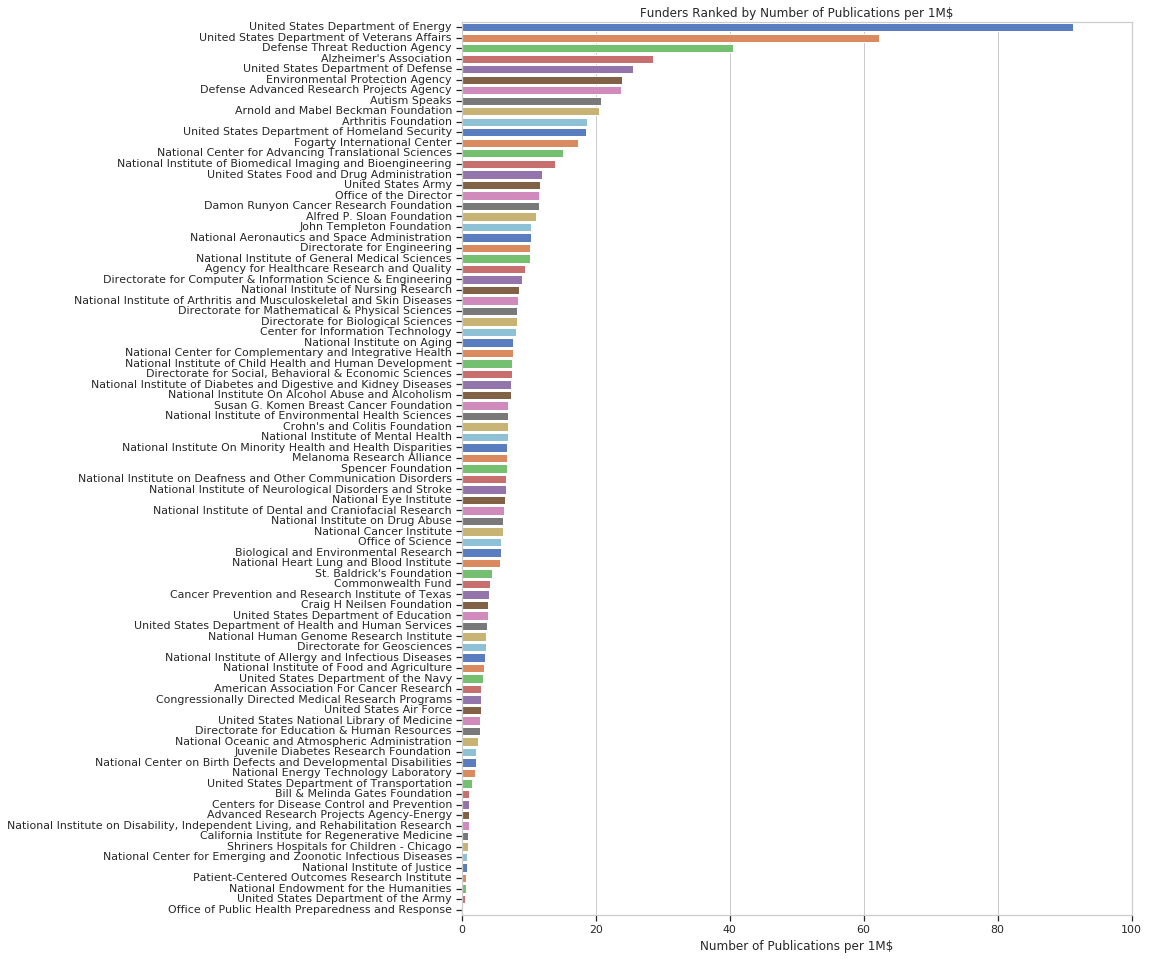

In [173]:
# Rank funders by publications per $
data['pub_per_$'] = data['count_publications'] * 1000000 / data['funding_corrected']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "pub_per_$", data=data.sort_values(by=['pub_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Number of Publications per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Number of Publications per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

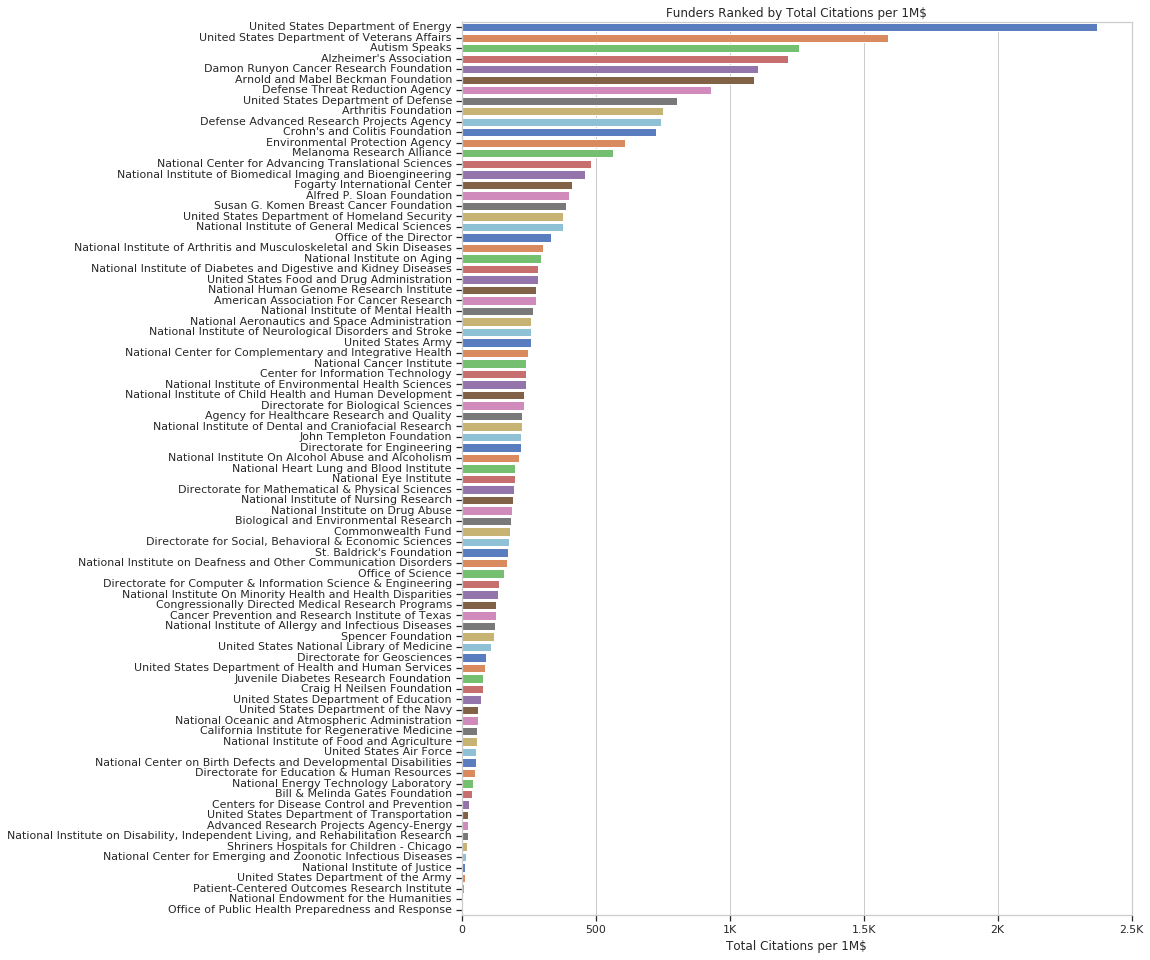

In [190]:
# Rank funders by publications per $
data['cite_total_per_$'] = data['citations_total'] * 1000000 / data['funding_corrected']

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "cite_total_per_$", data=data.sort_values(by=['cite_total_per_$'], ascending=False), orient="h", palette="muted")
ax.set_title('Funders Ranked by Total Citations per 1M$')
ax.set_ylabel('')
ax.set_xlabel('Total Citations per 1M$')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

## 6) Entropies as Diversity Metrics

In [228]:
# Calculate author entropy, according to Dimensions aggregations

data['author_entropy'] = 0.0
for index, row in data.iterrows(): 
    query = (
            'search publications ' +
            'where funder_countries = "US" ' + 
            ' and funders.name = "' + row['name'] + '" ' + 
            'and year in ' + years + 
            ' return researchers ' + 
            'limit 1000 '
        )
    df, stats = dimensions_to_df(query)
    E = scipy.stats.entropy(df['count'])
    data.loc[index, 'author_entropy'] = E
    print("Author Entropy for funder ", row['name'], "\n", E)

Author Entropy for funder  Advanced Research Projects Agency-Energy 
 6.745328794057745
Author Entropy for funder  Agency for Healthcare Research and Quality 
 6.747648075889271
Author Entropy for funder  Alfred P. Sloan Foundation 
 6.84568672237176
Author Entropy for funder  Alzheimer's Association 
 6.576718703635414
Author Entropy for funder  American Association For Cancer Research 
 6.818405574436039
Author Entropy for funder  Arnold and Mabel Beckman Foundation 
 6.617924305315619
Author Entropy for funder  Arthritis Foundation 
 6.730263329753238
Author Entropy for funder  Autism Speaks 
 6.675459210149604
Author Entropy for funder  Bill & Melinda Gates Foundation 
 6.763232800428217
Author Entropy for funder  Biological and Environmental Research 
 6.618620405647229
Author Entropy for funder  California Institute for Regenerative Medicine 
 6.730542738990256
Author Entropy for funder  Cancer Prevention and Research Institute of Texas 
 6.742649823695589
Author Entropy for fund

In [233]:
# Best and worst funders
data.sort_values(['author_entropy'])

,Unnamed: 0,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,...,funding_correction,funding_corrected,funding_avg,pub_per_$,cite_total_per_$,author_entropy,cite_total_per_$_log,org_entropy,author_entropy_log,org_entropy_log
68,68,Shriners Hospitals for Children - Chicago,2.233324e+08,439,SHC,2.000000,20.713376,3252.0,157,United States,...,4.053622e+07,1.827961e+08,1.164307e+06,0.858880,17.790311,6.022065,2.878654,3.936466,412.429298,51.237197
38,38,National Center on Birth Defects and Developme...,4.270682e+08,322,NCBDD,3.000000,25.158788,20756.0,825,United States,...,2.867410e+07,3.983941e+08,4.829020e+05,2.070814,52.099159,6.381930,3.953149,5.175529,591.067508,176.890234
64,64,Office of Public Health Preparedness and Response,3.786696e+09,99,OPHPR,3.000000,10.306233,3803.0,369,United States,...,1.666527e+05,3.786529e+09,1.026160e+07,0.097451,1.004350,6.404248,0.004340,4.629133,604.407190,102.425213
12,12,Center for Information Technology,1.102509e+08,35,CIT,3.000000,29.868594,22730.0,761,United States,...,1.538389e+07,9.486698e+07,1.246609e+05,8.021759,239.598651,6.416659,5.478965,5.219469,611.955395,184.836015
37,37,National Center for Emerging and Zoonotic Infe...,7.475601e+08,172,NCEZID,5.000000,17.201183,8721.0,507,United States,...,1.182422e+08,6.293179e+08,1.241258e+06,0.805634,13.857861,6.538206,2.628853,5.249507,691.045556,190.472387
84,84,United States National Library of Medicine,4.455510e+09,1122,NLM,4.000000,39.519691,439538.0,11122,United States,...,3.977362e+08,4.057774e+09,3.648421e+05,2.740912,108.319983,6.563765,4.685090,5.826980,708.936084,339.332460
3,3,Alzheimer's Association,2.059814e+08,1153,ALZ,7.000000,42.558326,201386.0,4732,United States,...,4.032238e+07,1.656590e+08,3.500824e+04,28.564703,1215.665958,6.576719,7.103047,6.054260,718.178901,425.923805
61,61,"National Institute on Disability, Independent ...",1.614527e+09,1070,NIDILRR,3.000000,21.402340,23778.0,1111,United States,...,4.789198e+08,1.135607e+09,1.022149e+06,0.978331,20.938574,6.580802,3.041593,5.267027,721.117081,193.838792
14,14,Commonwealth Fund,1.742925e+08,921,TCF,12.285714,42.911480,31025.0,723,United States,...,0.000000e+00,1.742925e+08,2.410685e+05,4.148198,178.005333,6.601818,5.181814,5.442044,736.432758,230.913643
81,81,United States Department of the Army,2.252775e+09,5907,DA,3.000000,27.774336,25108.0,904,United States,...,1.416494e+08,2.111126e+09,2.335316e+06,0.428207,11.893179,6.609633,2.475965,5.900174,742.210276,365.100910


In [232]:
# Calculate institution entropy, according to Dimensions aggregations

data['org_entropy'] = 0.0
for index, row in data.iterrows(): 
    query = (
            'search publications ' +
            'where funder_countries = "US" ' + 
            ' and funders.name = "' + row['name'] + '" ' + 
            'and year in ' + years + 
            ' return research_orgs ' + 
            'limit 1000 '
        )
    df, stats = dimensions_to_df(query)
    E = scipy.stats.entropy(df['count'])
    data.loc[index, 'org_entropy'] = E
    print("Org Entropy for funder ", row['name'], "\n", E)

Org Entropy for funder  Advanced Research Projects Agency-Energy 
 5.570695867574749
Org Entropy for funder  Agency for Healthcare Research and Quality 
 5.623201709498896
Org Entropy for funder  Alfred P. Sloan Foundation 
 5.901499290109832
Org Entropy for funder  Alzheimer's Association 
 6.054260469648974
Org Entropy for funder  American Association For Cancer Research 
 5.619378151763593
Org Entropy for funder  Arnold and Mabel Beckman Foundation 
 5.337917532270663
Org Entropy for funder  Arthritis Foundation 
 6.040652835714649
Org Entropy for funder  Autism Speaks 
 5.811987710590299
Org Entropy for funder  Bill & Melinda Gates Foundation 
 6.081443644999981
Org Entropy for funder  Biological and Environmental Research 
 5.570243125073408
Org Entropy for funder  California Institute for Regenerative Medicine 
 5.181011958541089
Org Entropy for funder  Cancer Prevention and Research Institute of Texas 
 4.997885737548933
Org Entropy for funder  Center for Information Technology 

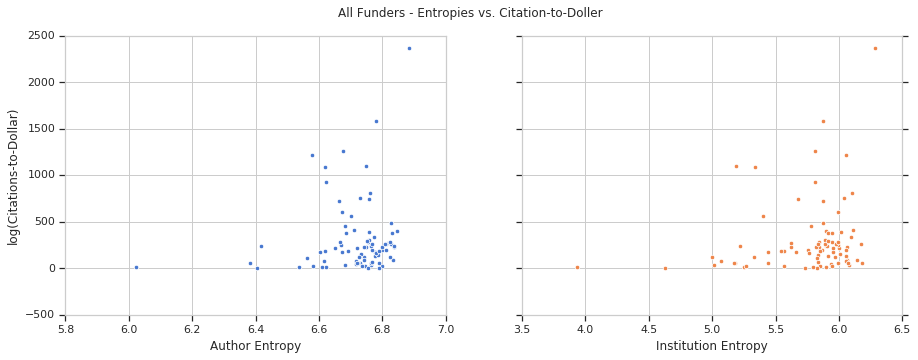

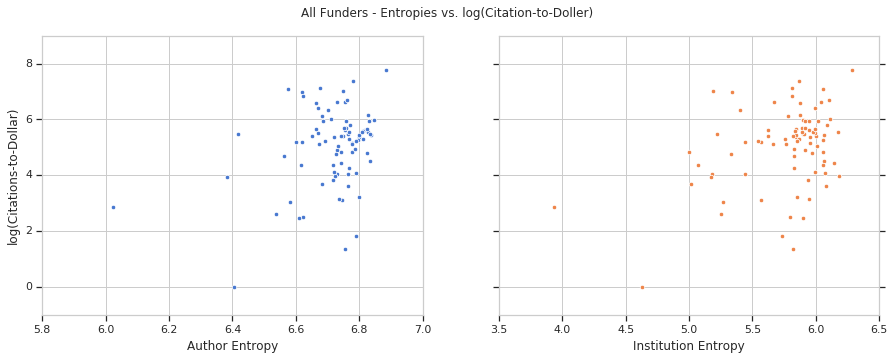

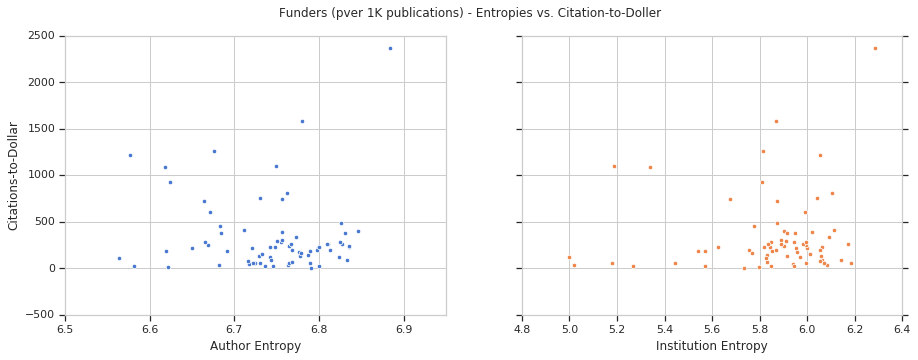

In [236]:
# Plot it
data["cite_total_per_$_log"] = np.log(data["cite_total_per_$"])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('All Funders - Entropies vs. Citation-to-Doller') 
colors = np.array(sns.color_palette("muted"))

sns.scatterplot(ax = axes[0], x="author_entropy", y="cite_total_per_$", data=data, color=colors[0])
axes[0].set_ylabel('log(Citations-to-Dollar)')
axes[0].yaxis.tick_left()
axes[0].set_xlabel('Author Entropy')
axes[0].xaxis.tick_bottom()

sns.scatterplot(ax = axes[1], x="org_entropy", y="cite_total_per_$", data=data, color=colors[1])
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_xlabel('Institution Entropy')
axes[1].xaxis.tick_bottom()

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('All Funders - Entropies vs. log(Citation-to-Doller)') 
colors = np.array(sns.color_palette("muted"))

sns.scatterplot(ax = axes[0], x="author_entropy", y="cite_total_per_$_log", data=data, color=colors[0])
axes[0].set_ylabel('log(Citations-to-Dollar)')
axes[0].yaxis.tick_left()
axes[0].set_xlabel('Author Entropy')
axes[0].xaxis.tick_bottom()

sns.scatterplot(ax = axes[1], x="org_entropy", y="cite_total_per_$_log", data=data, color=colors[1])
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_xlabel('Institution Entropy')
axes[1].xaxis.tick_bottom()

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Funders (pver 1K publications) - Entropies vs. Citation-to-Doller') 
colors = np.array(sns.color_palette("muted"))

sns.scatterplot(ax = axes[0], x="author_entropy", y="cite_total_per_$", data=data[data['count_publications'] > 1000], color=colors[0])
axes[0].set_ylabel('Citations-to-Dollar')
axes[0].yaxis.tick_left()
axes[0].set_xlabel('Author Entropy')
axes[0].xaxis.tick_bottom()

sns.scatterplot(ax = axes[1], x="org_entropy", y="cite_total_per_$", data=data[data['count_publications'] > 1000], color=colors[1])
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_xlabel('Institution Entropy')
axes[1].xaxis.tick_bottom()

plt.show()

## The End.

## Experiments... 

In [ ]:
funder = 'Defense Advanced Research Projects Agency'
funder_acronym = 'DARPA'

df_pubs = pd.read_csv('%s/%s.csv' % (pubs_data_dir, funder))[['concepts', 'year', 'author_affiliations']].dropna()
df_pubs.head(5)

In [77]:
import ast
"""
concepts_count = {}
for index, row in df_pubs.iterrows():
    concepts = [s.strip()[1:-1] for s in row['concepts'][1:-1].split(",")]
    for concept in concepts:
        concepts_count[concept] = concepts_count.get(concept, 0) + 1
print("Total number of concepts: ", len(concepts_count))
"""

author_count = {}
institute_count = {}
for index, row in df_pubs.iterrows():
    d = ast.literal_eval(row['author_affiliations'])[0]
    weight = 1 / float(len(d))
    for x in d:
        author = "%s %s" % (x['first_name'], x['last_name'])
        if len(x['affiliations']) > 0:
            author += " (%s)" % x['affiliations'][0]['name']
        author_count[author] = author_count.get(author, 0) + weight
        for aff in x['affiliations']:
            institute = aff['name']
            institute_count[institute] = institute_count.get(institute, 0) + (weight / len(x['affiliations']))

df_authors = pd.DataFrame.from_dict(author_count, orient='index', columns=['count'])   
df_authors = df_authors[df_authors['count'] >= 1]
df_institutes = pd.DataFrame.from_dict(institute_count, orient='index', columns=['count'])
df_institutes = df_institutes[df_institutes['count'] >= 1]
print("Total number of authors: ", len(author_count), "and institutes: ", len(df_institutes))

Total number of authors:  78571 and institutes:  1538


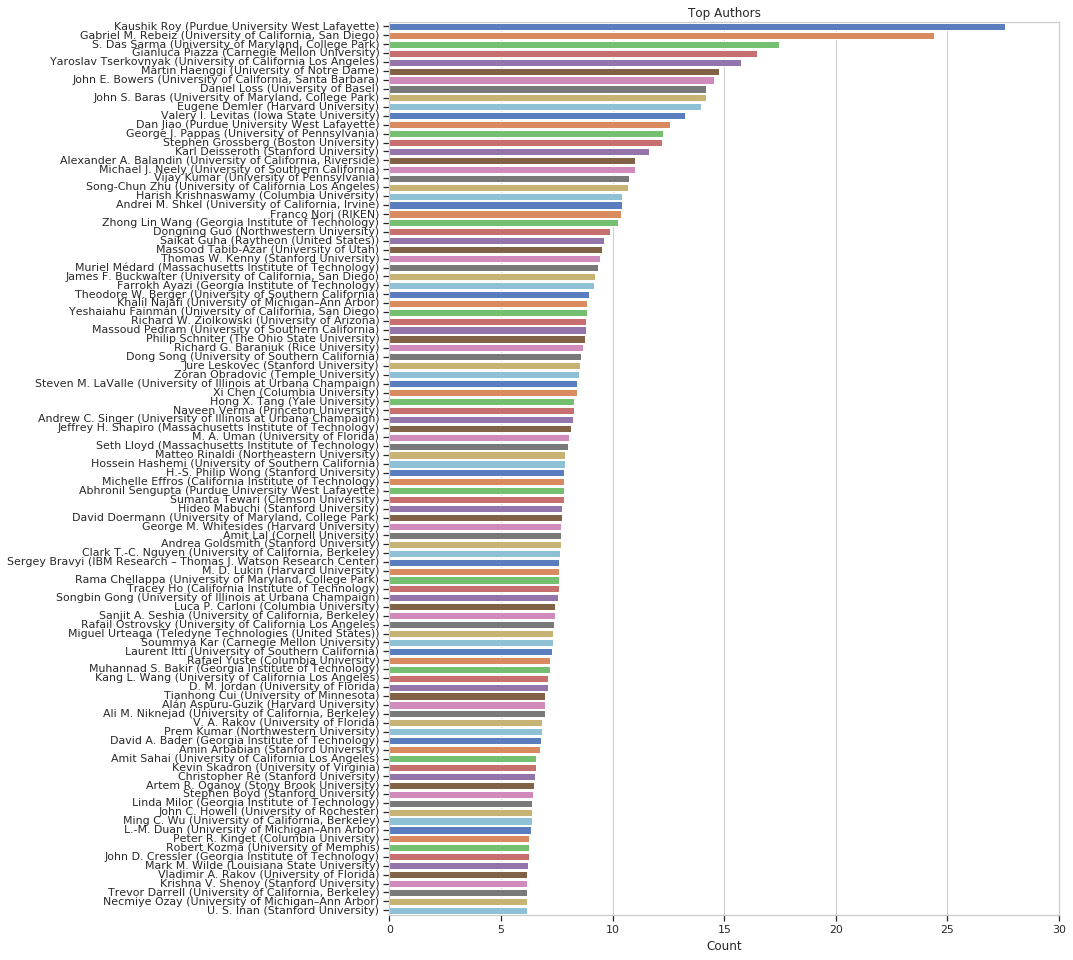

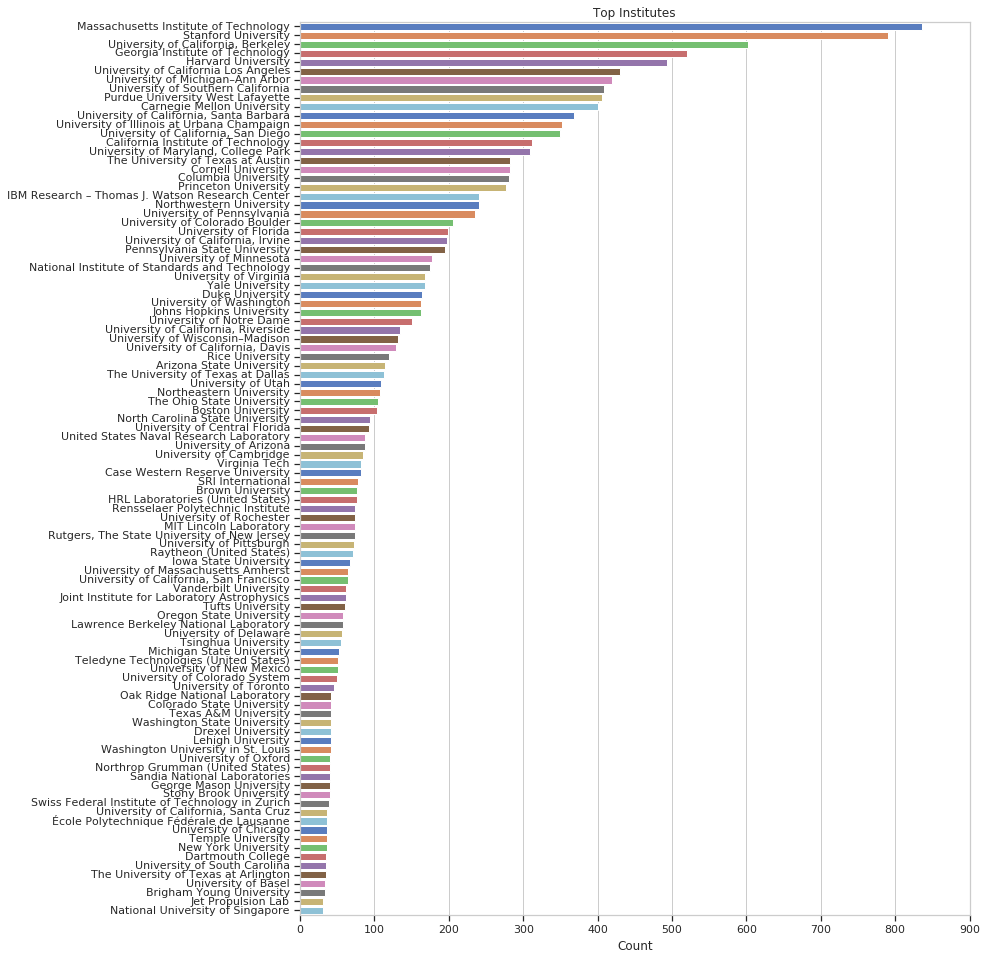

In [79]:
"""
df_concepts = pd.DataFrame.from_dict(concepts_count, orient='index', columns=['count'])
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y="index", x = "count", data=df_concepts.sort_values(by=['count'], ascending=False).reset_index().head(100), orient="h", palette="muted")
ax.set_title('Top Concepts')
ax.set_ylabel('')
ax.set_xlabel('Count')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.show()
"""

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y="index", x = "count", data=df_authors.sort_values(by=['count'], ascending=False).reset_index().head(100), orient="h", palette="muted")
ax.set_title('Top Authors')
ax.set_ylabel('')
ax.set_xlabel('Count')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.show()


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y="index", x = "count", data=df_institutes.sort_values(by=['count'], ascending=False).reset_index().head(100), orient="h", palette="muted")
ax.set_title('Top Institutes')
ax.set_ylabel('')
ax.set_xlabel('Count')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.show()

In [ ]:
dois = df_pubs['doi'].tolist()[0:10]

query_neo4j = """
MATCH (q:Quanta)
WHERE q.doi in {} 
RETURN count(*) as count_total, count(q.Disruption) as count_with_disruption, sum(q.Disruption) as sum_disruption
""".format(dois, len(dois))
df_neo4j = neo4j_to_df(query_neo4j, graph)

In [41]:
funders = [
    'Alfred P. Sloan Foundation',
    'Bill & Melinda Gates Foundation',
    'Defense Advanced Research Projects Agency',
    'United States Department of Defense'
]

data[data['name'].isin(funders)]

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg,funding_correction,funding_corrected,pub_per_$,cite_total_per_$
12,Bill & Melinda Gates Foundation,1.833299e+10,6425,BMGF,4.939394,35.349983,527952.0,14935,United States,3.606500,grid.418309.7,2.824802,4.326447e+09,1.400655e+10,1.066287,37.693228
58,Defense Advanced Research Projects Agency,1.167393e+09,2127,DARPA,3.000000,31.296025,806968.0,25785,United States,3.366668,grid.421816.8,1.897636,8.174105e+07,1.085652e+09,23.750706,743.302677
66,United States Department of Defense,7.866445e+08,1500,USDOD,3.000000,31.586209,551053.0,17446,United States,2.842986,grid.420391.d,2.081617,1.018549e+08,6.847896e+08,25.476438,804.704082
69,Alfred P. Sloan Foundation,6.830126e+08,1815,NaN,4.000000,35.875538,258268.0,7199,United States,4.011436,grid.453006.4,1.954173,3.457182e+07,6.484408e+08,11.102016,398.290801


In [86]:
data[data['name'].str.contains('Foundation')].sort_values('cite_total_per_$')

,name,funding,count_grants,acronym,altmetric_median,citations_avg,citations_total,count_publications,country_name,fcr_gavg,id,rcr_avg,funding_correction,funding_corrected,pub_per_$,cite_total_per_$
12,Bill & Melinda Gates Foundation,1.833299e+10,6425,BMGF,4.895604,35.349983,527952.0,14935,United States,3.606500,grid.418309.7,2.824802,4.326447e+09,1.400655e+10,1.066287,37.693228
80,Craig H Neilsen Foundation,1.590177e+08,1020,CHN,2.000000,19.626459,10088.0,514,United States,2.648153,grid.428355.d,1.751862,2.911461e+07,1.299031e+08,3.956795,77.657874
57,Juvenile Diabetes Research Foundation,1.185040e+09,2213,JDRF,3.000000,37.241346,77462.0,2080,United States,3.354089,grid.429307.b,1.879101,2.197048e+08,9.653355e+08,2.154691,80.243608
81,Spencer Foundation,1.474945e+08,1409,Spencer,4.000000,17.757576,17580.0,990,United States,3.723944,grid.453113.1,1.238762,0.000000e+00,1.474945e+08,6.712114,119.190866
76,St. Baldrick's Foundation,2.480550e+08,1206,SBF,4.000000,38.468220,36314.0,944,United States,3.698054,grid.430712.3,2.288043,3.478702e+07,2.132680e+08,4.426356,170.274056
64,John Templeton Foundation,8.827259e+08,1069,Templeton,4.000000,21.422606,166218.0,7759,United States,3.578975,grid.452951.e,1.718057,1.315474e+08,7.511785e+08,10.329103,221.276300
68,Susan G. Komen Breast Cancer Foundation,7.085244e+08,1710,Komen,3.000000,56.009877,232497.0,4151,United States,3.417876,grid.428834.1,2.322463,1.109975e+08,5.975269e+08,6.946968,389.098816
69,Alfred P. Sloan Foundation,6.830126e+08,1815,NaN,4.000000,35.875538,258268.0,7199,United States,4.011436,grid.453006.4,1.954173,3.457182e+07,6.484408e+08,11.102016,398.290801
72,Crohn's and Colitis Foundation,3.047268e+08,1292,CCF,5.000000,105.327221,183796.0,1745,United States,5.126348,grid.421660.7,4.593929,5.101938e+07,2.537074e+08,6.878002,724.440847
86,Arthritis Foundation,1.065859e+08,597,AF,3.000000,40.302417,61703.0,1531,United States,3.325254,grid.422901.c,1.925134,2.453460e+07,8.205131e+07,18.659055,752.005018


In [4]:

for funder in funders:
    print(funder)
    df_pubs = pd.read_csv('%s/%s.csv' % (pubs_data_dir, funder))
    print("total publications: %d" % len(df_pubs))
    df_supported_pubs = df_pubs.dropna(subset=['supporting_grant_ids'])
    print("total publications with supporting grants: %d" % len(df_supported_pubs))
    df_not_supported_pubs = df_pubs[df_pubs['supporting_grant_ids'].]


Alfred P. Sloan Foundation
total publications: 7206
total publications with supporting grants: 5195
Bill & Melinda Gates Foundation
total publications: 14935
total publications with supporting grants: 8892
Defense Advanced Research Projects Agency
total publications: 25820
total publications with supporting grants: 11682
United States Department of Defense
total publications: 17452
total publications with supporting grants: 10538


In [86]:
df_sloan["count"] = df_sloan["count"] * 100 / df_sloan["count"].sum()
df_bmgf["count"] = df_bmgf["count"] * 100 / df_bmgf["count"].sum()

df_FOR = pd.merge(df_sloan, df_bmgf, on=['id', 'name'], how='outer').drop(columns=['id'])
df_FOR.rename(columns={'count_x':'Sloan',
                                'count_y':'Bill & Melinda'},inplace=True)
df_FOR

,Sloan,name,Bill & Melinda
0,9.885021,0604 Genetics,7.203310
1,9.150431,0299 Other Physical Sciences,NaN
2,8.367934,0306 Physical Chemistry (incl. Structural),1.241301
3,8.016608,"0202 Atomic, Molecular, Nuclear, Particle and ...",NaN
4,7.649313,0601 Biochemistry and Cell Biology,4.438593
5,6.579368,0201 Astronomical and Space Sciences,NaN
6,6.212073,1109 Neurosciences,NaN
7,5.940594,1701 Psychology,1.222494
8,4.982434,0801 Artificial Intelligence and Image Processing,0.814996
9,4.104120,0912 Materials Engineering,NaN


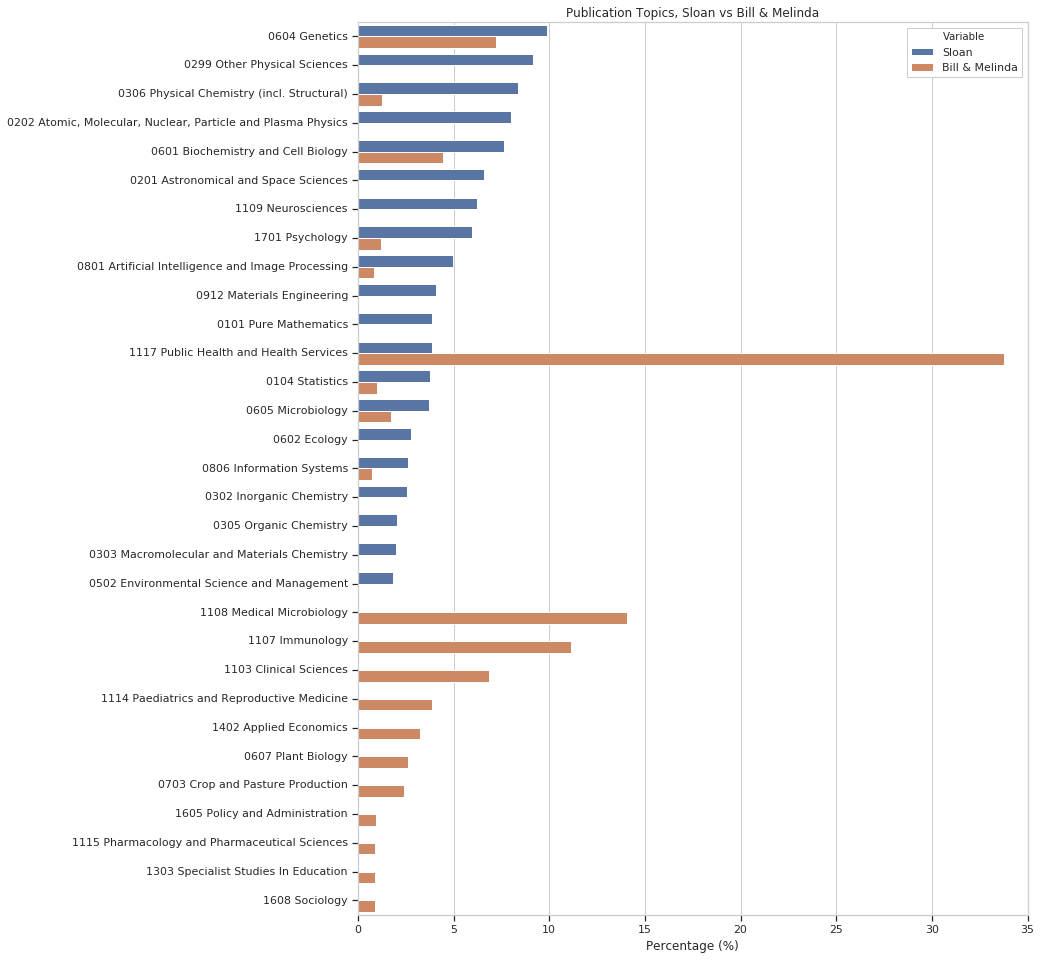

In [87]:
tidy = df_FOR.melt(id_vars='name').rename(columns=str.title)
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y='Name', x='Value', hue='Variable', data=tidy, orient="h")
ax.set_title('Publication Topics, Sloan vs Bill & Melinda')
ax.set_ylabel('')
ax.set_xlabel('Percentage (%)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()